# Project: Tweets Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li>
  <a href="#wrangling">Data Wrangling</a>
  <ol>
     <li><a href="#gather">Data Gathering</a></li>
     <li><a href="#assess">Data Assessing</a></li>
     <li><a href="#clean">Data Cleaning</a></li>   
   </ol>    
</li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

In [129]:
# import the packages will be used through the project
import numpy as np
import pandas as pd

# for twitter API
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

import requests
import tweepy
import json
import os
import re

# for Exploratory Data Analysis visually 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# activating the seaborn 
sns.set()

<a id='wrangling'></a>
## Data Wrangling



### 1- Gathering Data
<a id='gather'></a>

#### (A) gathering twitter archivement dog rates Data from the provided csv file


In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
twitter_archive.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### (B) Geting data from file (image_predictions.tsv) which is hosted on Udacity's servers and should be downloaded programmatically using the Requests library a

In [4]:
# Scrape the image predictions file from the Udacity website
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv' 
response = requests.get(url)
with open(os.path.join('image_predictions.tsv'), mode = 'wb') as file:
    file.write(response.content)

In [5]:
# Load the image predictions file 
# using \t beacuse it's "Tab Separated Value" file
images = pd.read_csv('image_predictions.tsv', sep = '\t')

In [6]:
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### (C) Getting data from twitter API 

In [7]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key =  'JRJCYqpq8QnnQde8W60rPUwwb'
consumer_secret = 'bysFJFrg0sjpWXmMV4EmePkOxLOPvmIgcbB3v0ZrwxrqhTD3bf'
access_token = '307362468-CwCujZZ0OaFQ3Ut2xf4dNlEkxuTVADOQkmhj6A2U'
access_secret = 'mYAXhcUOmPdUduQMyRbUXZrmcSPy36j7a9aqS6I4aHmWV'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [8]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to

# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
df_1 = twitter_archive
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1281: 708834316713893888
Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
13

Success
1530: 690248561355657216
Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
15

Success
1779: 677895101218201600
Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
18

Success
2028: 671874878652489728
Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
20

Success
2277: 667443425659232256
Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
23

In [9]:
# printing the len of the fails dict and the time in that had taken to make this list in minutes
len(fails_dict), 1834.9294512/60

(17, 30.58215752)

In [40]:
tweets_list = []
with open('tweet_json.txt', 'r') as json_file:
# Read the .txt file line by line into a list of dictionaries
    for line in json_file:
        twitter_data = json.loads(line)
        tweets_list.append({'tweet_id': twitter_data['id_str'],
                            'retweet_count': twitter_data['retweet_count'],
                            'favorite_count': twitter_data['favorite_count'],
                            'favorite_count': twitter_data['favorite_count'],
                            'followers_count': twitter_data['user']['followers_count']})
    

In [11]:
# Convert the list of dictionaries to a pandas DataFrame
tweets_data = pd.DataFrame(tweets_list, columns=['tweet_id',
                             'retweet_count', 'favorite_count', 'followers_count'])

In [12]:
tweets_data.head()

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,8213,37693,7924974
1,892177421306343426,6074,32376,7924974
2,891815181378084864,4016,24379,7924974
3,891689557279858688,8370,41010,7924974
4,891327558926688256,9074,39207,7924974


In [13]:
tweets_data.to_csv('tweets_data.csv')

### 2- Data Assessing
<a id='assess'></a>

#### (A) viusal Assessing 

In [14]:
# Display the twitter_archive table
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [35]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [16]:
twitter_archive[twitter_archive['expanded_urls'].isnull() == False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [15]:
twitter_archive['text'][1]

"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"

In [17]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [37]:
twitter_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [18]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

The columns of twitter_archive dataframe 
> * *tweet_id* =>  the unique identifier for each tweet.
> * *in_reply_to_status_id* => the id of replay tweet
> * *in_reply_to_user_id*   => the id of replay user       
> * *timestamp* => the tweet post time                    
> * *source*    => the url of the twitter                    
> * *text*      => text writen with the pic                    
> * *retweeted_status_id*  =>  retweeted status id       
> * *retweeted_status_user_id* => retweeted status user id     
> * *retweeted_status_timestamp* =>   
> * *expanded_urls* => the url of the twitter tweet                
> * *rating_numerator* =>    rating numerator          
> * *rating_denominator* =>  rating denominator         
> * *name*    => the name of the bog                      
> * *doggo*   => doggo dog breed                    
> * *floofer* => floofer dog breed                          
> * *pupper*  => pupper dog breed                      
> * *puppo*   => pupper dog breed



In [19]:
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [20]:
images.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [21]:
images.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

The columns of images dataframe and i'll use in my analysis
 > * tweet_id ==> tweet_id
 > * jpg_url ==> image link
 > * p1 the ==> probiltiy of a certen bread
 > * p1_conf ==> the probility of being this bread
 > * p1_dog the ==> if the value is true or false

In [22]:
# Display the tweets_data table
tweets_data.head()

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,8213,37693,7924974
1,892177421306343426,6074,32376,7924974
2,891815181378084864,4016,24379,7924974
3,891689557279858688,8370,41010,7924974
4,891327558926688256,9074,39207,7924974


In [23]:
# Display the tweets_data table
tweets_data.tail()

,tweet_id,retweet_count,favorite_count,followers_count
2334,666049248165822465,42,105,7925051
2335,666044226329800704,136,290,7925051
2336,666033412701032449,43,121,7925051
2337,666029285002620928,46,125,7925051
2338,666020888022790149,496,2518,7925051


In [24]:
tweets_data.sample(5)

,tweet_id,retweet_count,favorite_count,followers_count
556,801958328846974976,1854,8186,7924990
1650,682697186228989953,380,1369,7925034
1013,745712589599014916,2461,7263,7925003
628,793226087023144960,3110,10447,7924991
1033,743222593470234624,2005,6436,7925003


The columns of tweets_data dataframe
 > * tweet_id ==> the unique identifier for each tweet.
 > * retweet_num ==> image link
 > * favorite_num  ==> probiltiy of a certen bread
 > * followers_num ==> the probility of being this bread
----

#### (B) programming Assessing 


In [25]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [26]:
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [27]:
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Cooper        11
Oliver        11
Lucy          11
Lola          10
Penny         10
Tucker        10
Bo             9
Winston        9
the            8
Sadie          8
an             7
Toby           7
Buddy          7
Bailey         7
Daisy          7
Bella          6
Scout          6
Koda           6
Milo           6
Dave           6
Stanley        6
Leo            6
Jax            6
Jack           6
Oscar          6
Rusty          6
very           5
            ... 
Shelby         1
Loomis         1
Tessa          1
Shadoe         1
Bertson        1
Comet          1
Dallas         1
Jed            1
Taco           1
Dobby          1
Sage           1
Bodie          1
Superpup       1
Sobe           1
Huck           1
Lassie         1
Enchilada      1
Rascal         1
Linus          1
Tug            1
Nico           1
Monster        1
Clarkus        1
Kellogg        1
Gunner         1
Staniel        1
Zeek           1
Bode          

In [28]:
twitter_archive.isnull().sum().sum()

11140

In [32]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [33]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
650,792883833364439040,NaN,NaN,2016-10-31 00:20:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bailey. She's rather h*ckin hype for H...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792883833...,12,10,Bailey,None,None,None,None
506,812747805718642688,NaN,NaN,2016-12-24 19:52:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Sammy. At first I was like...,6.800555e+17,4.196984e+09,2015-12-24 16:00:30 +0000,https://twitter.com/dog_rates/status/680055455...,10,10,Sammy,None,None,None,None
488,813944609378369540,NaN,NaN,2016-12-28 03:08:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bruce. He never backs d...,7.902771e+17,4.196984e+09,2016-10-23 19:42:02 +0000,https://twitter.com/dog_rates/status/790277117...,11,10,Bruce,None,None,None,None
1875,675113801096802304,NaN,NaN,2015-12-11 00:44:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Zuzu. He just graduated college. Astute p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675113801...,10,10,Zuzu,None,None,pupper,None
690,787397959788929025,NaN,NaN,2016-10-15 21:01:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Moose. He's rather h*ckin dangerous (y...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/787397959...,11,10,Moose,None,None,None,None


In [34]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
445,819227688460238848,NaN,NaN,2017-01-11 17:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Finn. He's wondering if you come here ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819227688...,12,10,Finn,None,None,None,None
798,772877495989305348,NaN,NaN,2016-09-05 19:22:09 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",You need to watch these two doggos argue throu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772877495...,11,10,None,None,None,None,None
27,886736880519319552,NaN,NaN,2017-07-16 23:58:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mingus. He's a wonderful father to his...,NaN,NaN,NaN,"https://www.gofundme.com/mingusneedsus,https:/...",13,10,Mingus,None,None,None,None
580,800459316964663297,NaN,NaN,2016-11-20 22:02:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very sleepy pupper. Appears to be por...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/800459316...,12,10,None,None,None,pupper,None
2284,667192066997374976,NaN,NaN,2015-11-19 04:05:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*takes several long deep breaths* omg omg oMG ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667192066...,12,10,None,None,None,None,None


In [236]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [238]:
twitter_archive[twitter_archive['rating_denominator'] == 110]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121,110,None,None,None,None,None


In [29]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [30]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 4 columns):
tweet_id           2339 non-null object
retweet_count      2339 non-null int64
favorite_count     2339 non-null int64
followers_count    2339 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.2+ KB


In [31]:
tweets_data.isnull().sum()

tweet_id           0
retweet_count      0
favorite_count     0
followers_count    0
dtype: int64

### Quality issues:

#### Twitter archive (`twitter_archive`) table

* `tweet_id` data type is an int not a string
* `timestamp`, `retweeted_status_timestamp` are a string not datatime
* `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, retweeted_status_user_id they have alot of missing value as well as there data type is float not string.
* column `doggo`, `floofer`, `pupper`, `puppo`: values are 'None'  with type of string instead  instead of boolean(true, false) to be easy to use.
* removing the non need columns
* some names are just one lowercase letter
* clean the source to be only 3 values 
#### Image prediction (`images`) table

* tweet_id is an int type not string
* colomn `p1_dog`,`p2_dog`,`p3_dog`: sometimes all of them as false value or all of them have true value
* colomn p1 ,p2, p3 have names start with lowercase and uppercase so we have to make everything lower case
#### Twitter API (`tweets_data`) table
    has null values we should remove the rows with null

### Tidiness

#### Twitter archive (`twitter_archive`) table
- there are 2column for rate and they should be only one column
- `doggo`, `floofer`, `pupper` & `puppo` columns should be merged to one column named `dog_stage`

#### Image prediction (`images`) table

* Some column names need to be more descriptive,`jpg_url` to `img_link`.
* Image predictions table should be added to twitter archive table.


#### Twitter API (`tweets_data`) table

- twitter api table columns `retweet_count`, `favorite_count`, `followers_count` should be added to twitter archive table.




### 3- Data Cleaning 
<a id='clean'></a>

In [152]:
# making a copy to work one
archive_clean = twitter_archive.copy()
images_clean = images.copy()
tweets_clean = tweets_data.copy()

## Define
chaning the rate data type to be float

In [153]:
archive_clean.rating_numerator = archive_clean.rating_numerator.astype(float,copy=False)


In [154]:
# test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(5), int64(2), 

# Define 
 fixing the data in `rating_numerator` column 
 as in row `46` it's value should be 13.5 but it's only 5 in the data

In [155]:
# for avoiding "This pattern has match groups" error from ipython notebook
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [156]:
# diplaying the rows that has the problem
archive_clean[archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5.0
340,"RT @dog_rates: This is Logan, the Chow who liv...",75.0
695,"This is Logan, the Chow who lived. He solemnly...",75.0
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27.0
1689,I've been told there's a slight possibility he...,5.0
1712,Here we have uncovered an entire battalion of ...,26.0


In [157]:
# storing the index of the rows which have the problem
inds = archive_clean[archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")].index
inds

Int64Index([45, 340, 695, 763, 1689, 1712], dtype='int64')

In [158]:
def fix_rate(inds,col_name):
    # this function take the indexs and the column name we want to fix the rate in
    # extract the the true value from text columm
    # then fix the value in ratting_colimn
    # returns the fixed value
    for i in inds:
        txt = archive_clean.loc[i]['text']
        m = re.search(r"(\d+\.\d*\/\d+)", txt)
        n = (m.group(1)).split('/')[0]
        n = float(n)
        archive_clean.loc[i, col_name] = n
        
    return archive_clean.iloc[inds][col_name]


In [159]:
# fix the rating 
fix_rate(inds,'rating_numerator')    

45      13.50
340      9.75
695      9.75
763     11.27
1689     9.50
1712    11.26
Name: rating_numerator, dtype: float64

In [160]:
# test the fix
archive_clean[archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,13.50
340,"RT @dog_rates: This is Logan, the Chow who liv...",9.75
695,"This is Logan, the Chow who lived. He solemnly...",9.75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,11.27
1689,I've been told there's a slight possibility he...,9.50
1712,Here we have uncovered an entire battalion of ...,11.26


## Define 
    There are retweets should be removed


In [161]:
tweets_clean.drop('retweet_count',axis=1,inplace=True)

In [162]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id           2339 non-null object
favorite_count     2339 non-null int64
followers_count    2339 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


### define:
 removing the un unnecessary columns for my analysis

In [163]:
# drop the column form archive_clean table
archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls','text'],axis=1,inplace=True)

In [164]:
# test

archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
rating_numerator      2356 non-null float64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 184.1+ KB


In [165]:
# drop the column form archive_clean table
images.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Define:
the source column has 3 urls and it will be nicer and cleaner to make a word for each segmentation.

In [166]:
archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [167]:
url_1 = '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
url_2 = '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>'
url_3 = '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'
url_4 = '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'
ind_1 = archive_clean[archive_clean['source'] == url_1]['source'].index
ind_2 = archive_clean[archive_clean['source'] == url_2]['source'].index
ind_3 = archive_clean[archive_clean['source'] == url_3]['source'].index
ind_4 = archive_clean[archive_clean['source'] == url_4]['source'].index
archive_clean.loc[ind_1, 'source'] = 'twitter_for_iphone'
archive_clean.loc[ind_2, 'source'] = 'vine'
archive_clean.loc[ind_3, 'source'] = 'tweet_deck'
archive_clean.loc[ind_4, 'source'] = 'twitter_web'

In [168]:

archive_clean.source.value_counts()

twitter_for_iphone    2221
vine                    91
twitter_web             33
tweet_deck              11
Name: source, dtype: int64

In [169]:
# test
archive_clean.source.value_counts()

twitter_for_iphone    2221
vine                    91
twitter_web             33
tweet_deck              11
Name: source, dtype: int64

### define:
fix data types of the ids to make it easy to merge the tables
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html

In [170]:
# Convert tweet_id to str for the tables
archive_clean.tweet_id = archive_clean.tweet_id.astype(str,copy=False)
images_clean.tweet_id = images_clean.tweet_id.astype(str,copy=False)
archive_clean.tweet_id = archive_clean.tweet_id.astype(str,copy=False)



In [171]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2356 non-null object
timestamp             2356 non-null object
source                2356 non-null object
rating_numerator      2356 non-null float64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 184.1+ KB


Define:
some nomert

### Define:
fix the  to make the archive_clean timestamp datatype to be the datetime


In [172]:
# convert timestamp to datetime data type
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)


### define:
 fixing the name column in twitter_clean as there some name is just on the small letter, so I'll replace them by an empty string.

In [173]:
archive_clean.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5           None
6            Jax
7           None
8           Zoey
9         Cassie
10          Koda
11         Bruno
12          None
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
19        Canela
20        Gerald
21       Jeffrey
22          such
23        Canela
24          None
25          None
26          Maya
27        Mingus
28         Derek
29        Roscoe
          ...   
2326       quite
2327           a
2328        None
2329        None
2330        None
2331        None
2332        None
2333          an
2334           a
2335          an
2336        None
2337        None
2338        None
2339        None
2340        None
2341        None
2342        None
2343        None
2344        None
2345         the
2346         the
2347           a
2348           a
2349          an
2350           a
2351        None
2352           a
2353          

In [174]:
#replace names lowercase letters with ''
archive_clean.name = archive_clean.name.str.replace('(^[a-z]*)', '')

#replace '' letters with 'None'
archive_clean.name = archive_clean.name.replace('', 'None')


In [175]:
# test
archive_clean.name.value_counts()

None         854
Charlie       12
Lucy          11
Cooper        11
Oliver        11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
Sadie          8
Bailey         7
Buddy          7
Toby           7
Daisy          7
Jack           6
Stanley        6
Koda           6
Leo            6
Dave           6
Bella          6
Scout          6
Oscar          6
Milo           6
Rusty          6
Jax            6
Louis          5
Finn           5
Sammy          5
Phil           5
            ... 
Lance          1
Dylan          1
Banjo          1
Evy            1
Venti          1
Walker         1
Hazel          1
Sonny          1
Eevee          1
Al             1
Anna           1
Tilly          1
Vixen          1
Crawford       1
Ralf           1
Jameson        1
Ivar           1
Emmie          1
Kota           1
Furzey         1
Tuco           1
Carll          1
Sprinkles      1
Kingsley       1
Socks          1
Ginger         1
Jessifer       1
Mo            

In [176]:
#test for the letters
archive_clean.query('name == "(^[a-z]*)"').count()

tweet_id              0
timestamp             0
source                0
rating_numerator      0
rating_denominator    0
name                  0
doggo                 0
floofer               0
pupper                0
puppo                 0
dtype: int64

### define 
tweets_clean data have nulls and we have to remove them
so we'll drop all the nulls from or dataset

In [177]:
tweets_clean.isnull().sum()

tweet_id           0
favorite_count     0
followers_count    0
dtype: int64

In [178]:
tweets_data.isnull().sum()

tweet_id           0
retweet_count      0
favorite_count     0
followers_count    0
dtype: int64

In [179]:
tweets_clean.dropna(axis=0, inplace=True)


In [180]:
tweets_clean.isnull().sum()

tweet_id           0
favorite_count     0
followers_count    0
dtype: int64

### Define:
    in tweets_clean (from the API) we need to change the data type of favorite_count and followers_count to be int

In [185]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id           2339 non-null object
favorite_count     2339 non-null int32
followers_count    2339 non-null int32
dtypes: int32(2), object(1)
memory usage: 54.8+ KB


In [186]:
tweets_clean.favorite_count = tweets_clean.favorite_count.astype(int,copy=False)
tweets_clean.followers_count = tweets_clean.followers_count.astype(int,copy=False)

In [187]:
#test
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id           2339 non-null object
favorite_count     2339 non-null int32
followers_count    2339 non-null int32
dtypes: int32(2), object(1)
memory usage: 54.8+ KB


### define:
* column  p1 ,p2, p3 have names start with lowercase and uppercase so we have to make everything lower case


In [188]:
images_clean['p1'] = images_clean['p1'].str.lower()
images_clean['p2'] = images_clean['p2'].str.lower()
images_clean['p3'] = images_clean['p3'].str.lower()

In [189]:
#test
images_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


In [190]:
tweets_clean.head()

,tweet_id,favorite_count,followers_count
0,892420643555336193,37693,7924974
1,892177421306343426,32376,7924974
2,891815181378084864,24379,7924974
3,891689557279858688,41010,7924974
4,891327558926688256,39207,7924974


In [191]:
archive_clean.head()

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,twitter_for_iphone,13.0,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27+00:00,twitter_for_iphone,13.0,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03+00:00,twitter_for_iphone,12.0,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51+00:00,twitter_for_iphone,13.0,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24+00:00,twitter_for_iphone,12.0,10,Franklin,None,None,None,None


### Define
rename the jpg_url to img_link

In [192]:
images_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


In [193]:
images_clean.rename(columns={'jpg_url':'img_link'},inplace=True)

In [194]:
#test
images_clean.head()

,tweet_id,img_link,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


## (2) Tidy 

### Define:
1- making the rating_numerator and rating_denominator to one rating column in archive_clean 
then remove the two columns

In [195]:
# making and adding the column to the archive_clean dataset  
archive_clean['rating'] = archive_clean['rating_numerator']/archive_clean['rating_denominator']

In [196]:
#test
archive_clean.head()

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,twitter_for_iphone,13.0,10,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,twitter_for_iphone,13.0,10,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03+00:00,twitter_for_iphone,12.0,10,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51+00:00,twitter_for_iphone,13.0,10,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24+00:00,twitter_for_iphone,12.0,10,Franklin,None,None,None,None,1.2


In [197]:
# drop the rating_numerator and rating_denominator columns
archive_clean.drop(['rating_numerator','rating_denominator'],axis=1, inplace=True)


In [198]:
#test
archive_clean.head()

,tweet_id,timestamp,source,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,twitter_for_iphone,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,twitter_for_iphone,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03+00:00,twitter_for_iphone,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51+00:00,twitter_for_iphone,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24+00:00,twitter_for_iphone,Franklin,None,None,None,None,1.2


### Define:
2- making the doggo, floofer,pupper and	puppo to one dog_stage column in archive_clean 
then remove the two columns

In [199]:
#1- replace to all the null value in the column

def remove_None(df, col_name,value):
    # take the df name and col_name and return the col with no None word
    ind = df[df[col_name] == value][col_name].index
    df.loc[ind, col_name] = ''
    return df.head()

In [200]:
# replace to all the None value in the column
remove_None(archive_clean, 'doggo',"None")
remove_None(archive_clean, 'floofer',"None")
remove_None(archive_clean, 'pupper',"None")
remove_None(archive_clean, 'puppo',"None")


,tweet_id,timestamp,source,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,twitter_for_iphone,Phineas,,,,,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,twitter_for_iphone,Tilly,,,,,1.3
2,891815181378084864,2017-07-31 00:18:03+00:00,twitter_for_iphone,Archie,,,,,1.2
3,891689557279858688,2017-07-30 15:58:51+00:00,twitter_for_iphone,Darla,,,,,1.3
4,891327558926688256,2017-07-29 16:00:24+00:00,twitter_for_iphone,Franklin,,,,,1.2


In [201]:
# we will melt them together in dog_stage
archive_clean['dog_stage'] = archive_clean['doggo'] + archive_clean['floofer'] + archive_clean['pupper'] + archive_clean['puppo']

In [202]:
# test
archive_clean['dog_stage'].value_counts(), archive_clean['doggo'].value_counts()

(                1976
 pupper           245
 doggo             83
 puppo             29
 doggopupper       12
 floofer            9
 doggofloofer       1
 doggopuppo         1
 Name: dog_stage, dtype: int64,          2259
 doggo      97
 Name: doggo, dtype: int64)

In [203]:
# then we will take any unexpect value to be multiple 

archive_clean['dog_stage'].replace('', "multiple", inplace=True)
archive_clean['dog_stage'].replace('doggopupper', "multiple", inplace=True)
archive_clean['dog_stage'].replace('doggopuppo', "multiple", inplace=True)
archive_clean['dog_stage'].replace('doggofloofer', "multiple", inplace=True)

In [204]:
# test

archive_clean['dog_stage'].value_counts()

multiple    1990
pupper       245
doggo         83
puppo         29
floofer        9
Name: dog_stage, dtype: int64

In [205]:
# test
archive_clean.head()

,tweet_id,timestamp,source,name,doggo,floofer,pupper,puppo,rating,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,twitter_for_iphone,Phineas,,,,,1.3,multiple
1,892177421306343426,2017-08-01 00:17:27+00:00,twitter_for_iphone,Tilly,,,,,1.3,multiple
2,891815181378084864,2017-07-31 00:18:03+00:00,twitter_for_iphone,Archie,,,,,1.2,multiple
3,891689557279858688,2017-07-30 15:58:51+00:00,twitter_for_iphone,Darla,,,,,1.3,multiple
4,891327558926688256,2017-07-29 16:00:24+00:00,twitter_for_iphone,Franklin,,,,,1.2,multiple


In [206]:
# droping the columns out
archive_clean.drop(['doggo','floofer','pupper','puppo'],axis=1, inplace=True)

In [207]:
# test
archive_clean.head()

,tweet_id,timestamp,source,name,rating,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,twitter_for_iphone,Phineas,1.3,multiple
1,892177421306343426,2017-08-01 00:17:27+00:00,twitter_for_iphone,Tilly,1.3,multiple
2,891815181378084864,2017-07-31 00:18:03+00:00,twitter_for_iphone,Archie,1.2,multiple
3,891689557279858688,2017-07-30 15:58:51+00:00,twitter_for_iphone,Darla,1.3,multiple
4,891327558926688256,2017-07-29 16:00:24+00:00,twitter_for_iphone,Franklin,1.2,multiple


now the `archive_clean` ready to join the other tables

### define 
3- in the images_clean dataset i have picked from the 3 Ps one accourding to the highest confedent 

In [208]:
images_clean.head()

,tweet_id,img_link,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


In [209]:
#define dog_breed function to separate out the 3 columns of breed into one with highest confidence ratio
def get_p(r):
    max_num = max(r.p1_conf ,r.p2_conf, r.p3_conf) 
    if r.p1_conf == max_num:
        return r.p1
    elif r.p2_conf == max_num:
        return r.p2
    elif r.p3_conf == max_num:
        return r.p3
    

In [210]:
def get_p_conf(r):
    return max(r.p1_conf ,r.p2_conf, r.p3_conf)

In [211]:
images_clean['breed'] = images_clean.apply(get_p, axis=1)

In [212]:
images_clean['p_conf'] = images_clean.apply(get_p_conf, axis=1)

In [213]:
images_clean.head()

,tweet_id,img_link,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,p_conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,german_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,miniature_pinscher,0.560311


In [214]:
# droping the columns
images_clean.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],axis=1,inplace=True)


In [215]:
# test
images_clean.head()

,tweet_id,img_link,img_num,breed,p_conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


 ### now the data is clean so we ready to marge them to on column 

In [216]:
#merge the two tables
twitter_archive_master = pd.merge(left=archive_clean, right=images_clean, how='inner', on='tweet_id')
twitter_archive_master = pd.merge(left=twitter_archive_master, right=tweets_clean, how='inner', on='tweet_id')
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 12 columns):
tweet_id           2066 non-null object
timestamp          2066 non-null datetime64[ns, UTC]
source             2066 non-null object
name               2066 non-null object
rating             2066 non-null float64
dog_stage          2066 non-null object
img_link           2066 non-null object
img_num            2066 non-null int64
breed              2066 non-null object
p_conf             2066 non-null float64
favorite_count     2066 non-null int32
followers_count    2066 non-null int32
dtypes: datetime64[ns, UTC](1), float64(2), int32(2), int64(1), object(6)
memory usage: 193.7+ KB


In [217]:
twitter_archive_master.head()

,tweet_id,timestamp,source,name,rating,dog_stage,img_link,img_num,breed,p_conf,favorite_count,followers_count
0,892420643555336193,2017-08-01 16:23:56+00:00,twitter_for_iphone,Phineas,1.3,multiple,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,37693,7924974
1,892177421306343426,2017-08-01 00:17:27+00:00,twitter_for_iphone,Tilly,1.3,multiple,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581,32376,7924974
2,891815181378084864,2017-07-31 00:18:03+00:00,twitter_for_iphone,Archie,1.2,multiple,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012,24379,7924974
3,891689557279858688,2017-07-30 15:58:51+00:00,twitter_for_iphone,Darla,1.3,multiple,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,41010,7924974
4,891327558926688256,2017-07-29 16:00:24+00:00,twitter_for_iphone,Franklin,1.2,multiple,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,39207,7924974


## saving the clean data

In [218]:
# saving the data fram to csv file
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)
# saving the data fram to sqlite file (data base)


In [219]:
df = twitter_archive_master

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1 : what's the most popular dog_stage ?

In [220]:
counts = df['dog_stage'].value_counts()[1:]
uni = counts.index
counts

pupper     211
doggo       67
puppo       23
floofer      7
Name: dog_stage, dtype: int64

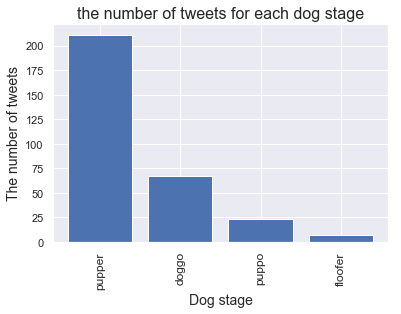

In [221]:

# gentarting a list of the loc or the index for each  to be replaced by the tick 
locs = np.arange(len(uni))
plt.bar(locs, counts)
plt.xlabel('Dog stage', fontsize=14)
plt.ylabel('The number of tweets', fontsize=14)
# Set text labels:
plt.xticks(locs, uni, fontsize=12, rotation=90)
plt.title('the number of tweets for each dog stage', fontsize=16)
plt.show()

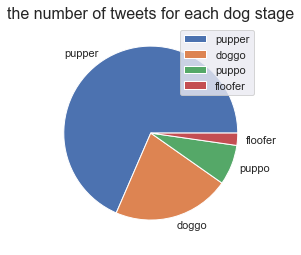

In [222]:
#ploting it in pie chart
plt.pie(counts, labels=uni)
plt.title('the number of tweets for each dog stage', fontsize=16)
plt.legend();

#### by ignoring the number of unknowns, from our data we can see that:
> The greatest number of tweets about the dogs are in pupper dogs with 1055 tweets.  
>
> the "doggo"dogs has 335 tweets.
>
> 115 tweets for puppo dogs.
>
> 35 tweets for floofer dogs and it's the lowest number of tweets.



### Research Question 2 : what's the most popular dog_stage according to rating average?

In [223]:
rating = df['rating'].groupby(df['dog_stage']).mean()[:-1].sort_values(ascending=False)
rating

dog_stage
floofer     1.200000
doggo       1.197015
multiple    1.175218
pupper      1.068374
Name: rating, dtype: float64

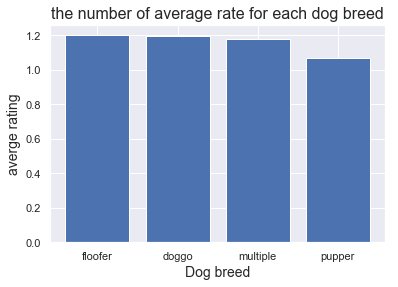

In [224]:
#polting the values in barchat
dog_stage = rating.index

plt.bar(dog_stage, rating)
plt.xlabel('Dog breed', fontsize=14)
plt.ylabel('averge rating', fontsize=14)
# Set text labels:
plt.title('the number of average rate for each dog breed', fontsize=16)
plt.show()

> from the bar chat we can see that the floofer dogs tweets  1.2 average rating and the puppo tweets have avrage rating 1.197
> while the doggo tweets have 1.197 rate. 
> and the pupper tweets have 1.068 rate. 
>
>

### Research Question 3  what are the top 10 bead that has the most number of tweets ?

In [225]:
top_breads = df['breed'].value_counts()[:10]
topbreds_uni = top_breads.index
top_breads

golden_retriever      150
labrador_retriever     99
pembroke               88
chihuahua              81
pug                    57
chow                   44
samoyed                42
toy_poodle             39
pomeranian             38
malamute               30
Name: breed, dtype: int64

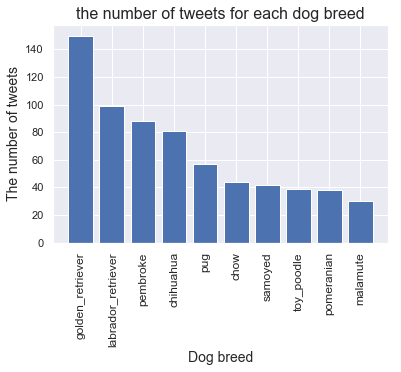

In [226]:
# gentarting a list of the loc or the index for each breed to be replaced by the tick 
locs = np.arange(len(topbreds_uni))
plt.bar(locs, top_breads)
plt.xlabel('Dog breed', fontsize=14)
plt.ylabel('The number of tweets', fontsize=14)
# Set text labels:
plt.xticks(locs, topbreds_uni, fontsize=12, rotation=90)
plt.title('the number of tweets for each dog breed', fontsize=16)
plt.show()

The top 10 bead that has the most number of tweets are golden_retriever with 750 tweets, labrador_retriever with 495 tweets, pembroke 440 tweets , chihuahua for 405 tweets,285 tweets about pug dogs,220 about chow dogs,210 about samoyed dogs,195 about the toy poodle dogs,190 tweets about pomeranian dogs,150 tweets about the malamute dogs.

### Research Question 4  what's the number of retweets form each source ?

In [234]:
df['rating'].groupby(df['source']).mean().sort_values(ascending=False)

source
tweet_deck            18.770000
twitter_for_iphone     1.080830
twitter_web            1.006667
Name: rating, dtype: float64

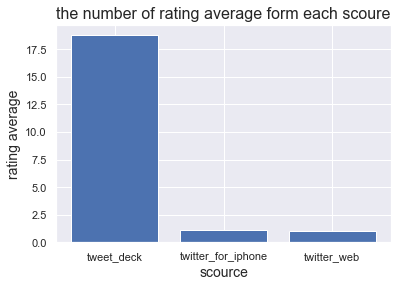

In [233]:
retweets = df['rating'].groupby(df['source']).mean().sort_values(ascending=False)
source = retweets.index

plt.bar(source, retweets)
plt.xlabel('scource', fontsize=14)
plt.ylabel('rating average', fontsize=14)
plt.title('the number of rating average form each scoure', fontsize=16)
plt.show()

>the average rate source is twitter for iphone with 18.77(about 19) 
>
>then twitter web with 1.008 average rate
>
> 1.006 average rate from tweet deck

### Research Question 5  what are the top 4 images that has the most favorite_counts ?

In [229]:
images = df['favorite_count'].groupby(df['img_link']).sum().sort_values(ascending=False).iloc[:4]
image_lbl = []
for i in range(len(images)):
    x = df[df['img_link'] == images.index[i]]['breed'].iloc[0]
    image_lbl.append(x)
dog_stage= []
for i in range(len(images)):
    x = df[df['img_link'] == images.index[i]]['dog_stage'].iloc[0]
    dog_stage.append(x)
image_lbl, dog_stage

(['labrador_retriever', 'lakeland_terrier', 'chihuahua', 'french_bulldog'],
 ['doggo', 'puppo', 'multiple', 'pupper'])

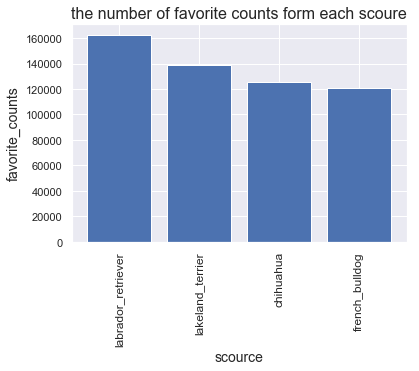

In [230]:
plt.bar(image_lbl, images)
plt.xlabel('scource', fontsize=14)
plt.ylabel('favorite_counts', fontsize=14)
plt.title('the number of favorite counts form each scoure', fontsize=16)
plt.xticks(image_lbl, image_lbl, fontsize=12, rotation=90)

plt.show()



## the top first image is labrador retriever image  with  813685 favoirte count
![Otter](https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg)

----
## then  this image of a lakeland terrier dog with  695300 favoirte count

![Otter](https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg)

----
## then this image of a chihuahua dog with  629030 favoirte count

![Otter](https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg)

----
## then this image of a with french bulldog 604450 favoirte count

![Otter](https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg)

<a id='conclusions'></a>
## Conclusions
> The greatest number of tweets about the dogs are in pupper dogs with 1055 tweets
>
> however only 35 tweets about floofer dogs.
>
> we can see that the floofer dogs tweets and the puppo tweets have the highest avrage rating 1.2 while the doggo tweets have 1.197 rate. and the pupper tweets have 1.076 rate.
>
> the most number of tweets 750 tweets are about golden retriever  

> 


## Limitations¶
> I have removed alot of data ethier for missing value(id)
>
> I have removed column of beed with 3 probabilities and I have take the highest probabilities the data with the highest probability.
>
> I want the original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.



# Resourses
> [How to lowercase a python dataframe string column if it has missing values?](https://stackoverflow.com/questions/22245171/how-to-lowercase-a-python-dataframe-string-column-if-it-has-missing-values)
>
> [Twitter API - get tweets with specific id](https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id)
>
>[pandas astype](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)
>
>[Extract word from string Using python regex](https://stackoverflow.com/questions/24885262/extract-word-from-string-using-python-regex)
>

# Thanks for reviewing my project.

I would be happy to keep in touch with you.

>LinkedIn :[@AbdElrhman-m]('https://www.linkedin.com/in/abdelrhman-m/')
>
>Email : AbdElrhman.m056@gmail.com